In [2]:

from torch_snippets import *
from PIL import Image
import glob
IMAGE_ROOT = '../Frames/Training Frames'
import xml.etree.ElementTree as ET
from typing import Dict, List
from tqdm import tqdm
import re
import pandas as pd
from torch_snippets import Report
import cv2 as cv

/home/user/anaconda3/envs/harshita_env/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:

def parse_xml_file(objects,filename):
    ann_tree = ET.parse(filename)       #'../Annotations/DD/VOC XML/21_01_25_01_DD/21_01_25_01_DD_Ch1_20210125154231_frame_123.xml'
    ann_root = ann_tree.getroot()
    #objects=[]
    size_obj=ann_root.find('size')
    height=float(size_obj.findtext('height'))
    width=float(size_obj.findtext('width'))
    
    for obj in ann_root.findall('object'):
        bb={}
        bb['imageID']=ann_root.findtext('filename')[:-4]+'.jpg'
        bb['LabelName']=obj.findtext('name')
        bb_obj=obj.find('bndbox')
        if (int(bb_obj.findtext('xmin')) >= int(bb_obj.findtext('xmax'))) or (int(bb_obj.findtext('ymin')) >= int(bb_obj.findtext('ymax'))):
            print('Invalid count')
            continue
        bb['XMin']=(float(bb_obj.findtext('xmin')))/width
        bb['XMax']=(float(bb_obj.findtext('xmax')))/width

        bb['YMin']=(float(bb_obj.findtext('ymin')))/height
        bb['YMax']=(float(bb_obj.findtext('ymax')))/height
        bb['Confidence']=1
        
        objects.append(bb)



In [5]:
list_of_folders=['../Annotations/DD/VOC XML/','../Annotations/TD/VOC XML/']
objects=[]

for folder in list_of_folders:
    videos=[f for f in os.listdir(folder) if os.path.isdir(os.path.join(folder,f))]
    for video in videos:
        full_path=os.path.join(folder,video)
        files = [os.path.join(full_path,f) for f in os.listdir(full_path)]
        for f in files:
            parse_xml_file(objects,f)

df=pd.DataFrame(objects)

Invalid count

Invalid count

Invalid count

In [21]:
df

,imageID,LabelName,XMin,XMax,YMin,YMax,Confidence
0,21_01_25_01_DD_Ch2_20210125154225_frame_151.jpg,BLOCKS,0.475000,0.492188,0.511111,0.547222,1
1,21_01_25_01_DD_Ch2_20210125154225_frame_151.jpg,BLOCKS,0.450000,0.468750,0.521296,0.546296,1
2,21_01_25_01_DD_Ch1_20210125154231_frame_123.jpg,RATTLE,0.560417,0.644792,0.806481,0.858333,1
3,21_01_25_01_DD_Ch1_20210125154231_frame_123.jpg,BALL,0.626042,0.673958,0.752778,0.838889,1
4,21_01_25_01_DD_Ch4_20210125154225_frame_19.jpg,BANANA,0.318229,0.368229,0.591667,0.663889,1
...,...,...,...,...,...,...,...
1348,22_06_08_01_TD_Ch2_20220608102943_frame_3.jpg,BLOCKS,0.417187,0.432812,0.387963,0.409259,1
1349,22_06_08_01_TD_Ch2_20220608102943_frame_9.jpg,BLOCKS,0.466146,0.484375,0.394444,0.420370,1
1350,22_06_08_01_TD_Ch2_20220608102943_frame_23.jpg,BANANA,0.507812,0.533854,0.294444,0.368519,1
1351,22_06_08_01_TD_Ch2_20220608102943_frame_4.jpg,BLOCKS,0.551562,0.568750,0.640741,0.666667,1


In [22]:
len(df)

1353

In [23]:
#df=pd.read_csv('df_temp.csv')

In [6]:
label2target = {l:t+1 for t,l in enumerate(df['LabelName'].unique())}
label2target['background'] = 0
target2label = {t:l for l,t in label2target.items()}
background_class = label2target['background']
num_classes = len(label2target)

In [7]:
def preprocess_image(img):
    img = torch.tensor(img).permute(2,0,1)
    return img.to(device).float()

In [8]:
class OpenDataset(torch.utils.data.Dataset):
    w, h = 224, 224
    def __init__(self, df, image_dir=IMAGE_ROOT):
        self.image_dir = image_dir
        self.files = glob.glob(self.image_dir+'/*')
        self.df = df
        self.image_infos = df.imageID.unique()
    def __getitem__(self, ix):
        # load images and masks
        image_id = self.image_infos[ix]
        img_path = find(image_id, self.files)
        # print('Image id : ',image_id)
        # print('Image path : ',img_path)
        # img = Image.open(img_path,'r').convert("RGB")
        # img = np.array(img.resize((self.w, self.h), resample=Image.BILINEAR))/255.

        img=cv.imread(img_path)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB).astype(np.float32)

        img=cv.resize(img,(self.w,self.h))
        img=img/255.0

        data = df[df['imageID'] == image_id]
        labels = data['LabelName'].values.tolist()
        data = data[['XMin','YMin','XMax','YMax']].values
        data[:,[0,2]] *=self.w
        data[:,[1,3]] *=self.h
        #print(data)
        #boxes = data.astype(np.uint32).tolist() # convert to absolute coordinates
        boxes = data.tolist()
        # torch FRCNN expects ground truths as a dictionary of tensors
        target = {}
        target["boxes"] = torch.Tensor(boxes).float()
        target["labels"] = torch.Tensor([label2target[i] for i in labels]).long()
        img = preprocess_image(img)
        return img, target
    def collate_fn(self, batch):
        #print(tuple(zip(*batch)))
        return tuple(zip(*batch)) 

    def __len__(self):
        return len(self.image_infos)


In [9]:

from sklearn.model_selection import train_test_split
trn_ids, val_ids = train_test_split(df.imageID.unique(), test_size=0.1, random_state=99,shuffle=False)
trn_df, val_df = df[df['imageID'].isin(trn_ids)], df[df['imageID'].isin(val_ids)]
#print(len(trn_df), len(val_df))

train_ds = OpenDataset(trn_df)
test_ds = OpenDataset(val_df)

train_loader = DataLoader(train_ds, batch_size=16, collate_fn=train_ds.collate_fn, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=16, collate_fn=test_ds.collate_fn, drop_last=True)

In [28]:
# corrupt_images=[]
# for i in range(len(trn_ids)):
#         try:
#             img_id=train_ds[i]
#         except:
#             corrupt_images.append(img_id)

In [29]:
#corrupt_images

In [10]:

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

device = 'cuda' if torch.cuda.is_available() else 'cpu'

def get_model():
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [31]:
def train_batch(inputs, model, optimizer):
    model.train()
    input, targets = inputs
    input = list(image.to(device) for image in input)
    #print(targets)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    optimizer.zero_grad()
    losses = model(input, targets)
    loss = sum(loss for loss in losses.values())
    loss.backward()
    optimizer.step()
    return loss, losses

@torch.no_grad() # this will disable gradient computation in the function below
def validate_batch(inputs, model):
    model.train() # to obtain the losses, model needs to be in train mode only. # #Note that here we are not defining the model's forward method 
#and hence need to work per the way the model class is defined
    input, targets = inputs
    input = list(image.to(device) for image in input)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    optimizer.zero_grad()
    losses = model(input, targets)
    loss = sum(loss for loss in losses.values())
    return loss, losses

In [32]:

model = get_model().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
n_epochs = 16
log = Report(n_epochs)

/home/user/anaconda3/envs/harshita_env/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/home/user/anaconda3/envs/harshita_env/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [33]:
import traceback
for epoch in range(n_epochs):
    _n = len(train_loader)
    for ix, inputs in enumerate(train_loader):
    
       
            #print('Batch no. : ',ix,inputs)
            loss, losses = train_batch(inputs, model, optimizer)
            loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = \
                [losses[k] for k in ['loss_classifier','loss_box_reg','loss_objectness','loss_rpn_box_reg']]
            pos = (epoch + (ix+1)/_n)
            log.record(pos, trn_loss=loss.item(), trn_loc_loss=loc_loss.item(), trn_regr_loss=regr_loss.item(), trn_objectness_loss=loss_objectness.item(),trn_rpn_box_reg_loss=loss_rpn_box_reg.item(), end='\r')
    

    _n = len(test_loader)
    print('Validation started : ',_n)
    for ix,inputs in enumerate(test_loader):
                loss, losses = validate_batch(inputs, model)
                loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = \
                [losses[k] for k in ['loss_classifier','loss_box_reg','loss_objectness','loss_rpn_box_reg']]
                pos = (epoch + (ix+1)/_n)
                log.record(pos, val_loss=loss.item(), val_loc_loss=loc_loss.item(),val_regr_loss=regr_loss.item(), val_objectness_loss=loss_objectness.item(), val_rpn_box_reg_loss=loss_rpn_box_reg.item(), end='\r')
    if (epoch+1)%(n_epochs//5)==0: log.report_avgs(epoch+1)


EPOCH: 1.000  trn_loss: 0.423  trn_loc_loss: 0.205  trn_regr_loss: 0.186  trn_objectness_loss: 0.026  trn_rpn_box_reg_loss: 0.007  (1499.22s - 0.00s remaining)))

Validation started :  4

EPOCH: 1.000  val_loss: 0.328  val_loc_loss: 0.154  val_regr_loss: 0.125  val_objectness_loss: 0.020  val_rpn_box_reg_loss: 0.028  (1561.81s - 0.00s remaining)g))

ZeroDivisionError: integer division or modulo by zero

In [ ]:
orig_image=cv.imread('..frames/ASD/21_01_11_01_AD/21_01_11_01_AD_Ch1_20210111150351_frame_166.jpg')
img=


In [ ]:
torch.__version__

In [ ]:
log.plot_epochs(['trn_loss','val_loss'])

In [ ]:
trn_ids

In [16]:

from torchvision.ops import nms
def decode_output(output):
    'convert tensors to numpy arrays'
    bbs = output['boxes'].cpu().detach().numpy().astype(np.uint16)
    labels = np.array([target2label[i] for i in output['labels'].cpu().detach().numpy()])
    confs = output['scores'].cpu().detach().numpy()
    ixs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.05)
    bbs, confs, labels = [tensor[ixs] for tensor in [bbs, confs, labels]]

    if len(ixs) == 1:
        bbs, confs, labels = [np.array([tensor]) for tensor in [bbs, confs, labels]]
    return bbs.tolist(), confs.tolist(), labels.tolist()
     

In [ ]:


img = Image.open('../Frames/Training Frames/22_06_08_01_TD_Ch2_20220608102943_frame_2.jpg').convert("RGB")
img = np.array(img.resize((224, 224), resample=Image.BILINEAR))/255.

## Visualizing results

In [64]:
model= get_model()
model.load_state_dict(torch.load('Faster_RCNN_Trained_1500'))
model.eval()


def visualize_test_results(orig_image_path,model):
    
    orig_image=cv.imread(orig_image_path)
    img = cv.cvtColor(orig_image, cv.COLOR_BGR2RGB).astype(np.float32)

    img=cv.resize(img,(224,224))
    img=img/255.0

    img = torch.tensor(img).permute(2,0,1)
    img=img.float()

    output=model([img])
    bbs,confs,labels=decode_output(output[0])
    height, width, _ = orig_image.shape
    print(labels,confs)
    for box,label,conf in zip(bbs,labels,confs):
            if conf>0.15:
                
                cv.rectangle(orig_image,(int(box[0]*width/224), int(box[1]*height/224)),(int(box[2]*width/224), int(box[3]*height/224)),(0, 0, 255), 2)
                cv2.putText(orig_image, label+'('+str(round(conf,2))+')', (int(box[0]*width/224), int(box[1]*height/224)-10), cv.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)
    plt.figure(figsize = (15,15))           
    plt.imshow(orig_image, interpolation='nearest', aspect='auto')
    plt.savefig('Test_Results/'+orig_image_path.split('/')[-1])


/home/user/anaconda3/envs/harshita_env/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/home/user/anaconda3/envs/harshita_env/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


['DOLL', 'BELL', 'BELL', 'DOLL', 'DOLL', 'BLOCKS', 'BLOCKS', 'TOYPHONE', 'TOYPHONE']
[
    0.9367731809616089,
    0.06744050234556198,
    0.06744050234556198,
    0.06633451581001282,
    0.06633451581001282,
    0.06532511860132217,
    0.06532511860132217,
    0.06113338842988014,
    0.06113338842988014
]

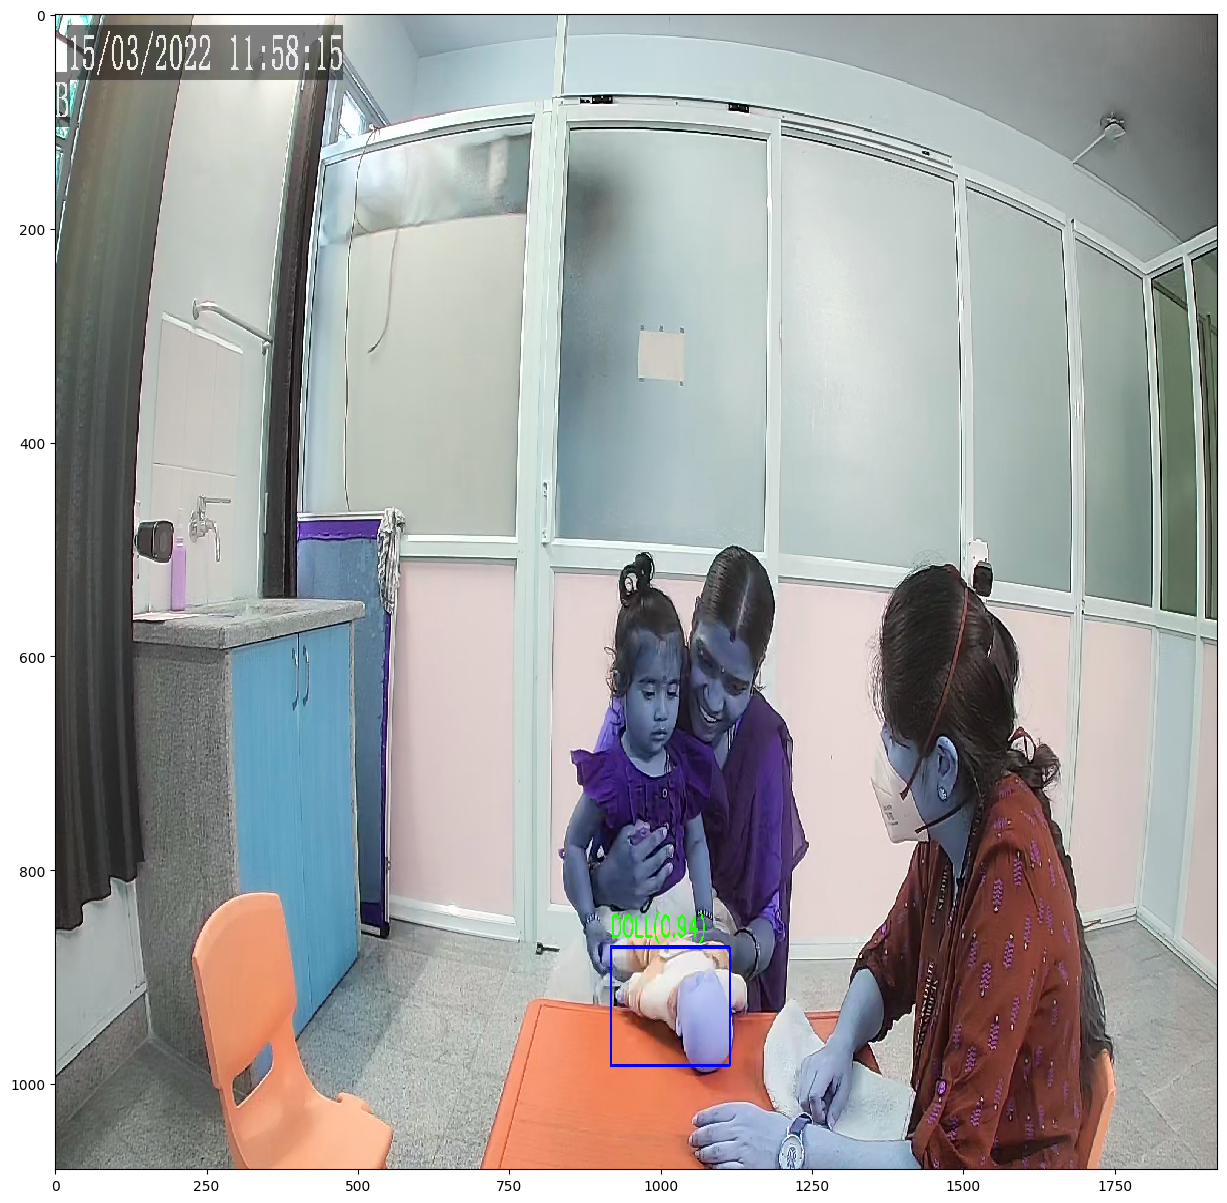

In [71]:
visualize_test_results('../Frames/TD/22_03_10_01_TD/22_03_10_01_TD_Ch1_20220315114953_frame_111.jpg',model)

In [38]:
confs

[0.9379213452339172,
 0.6263901591300964,
 0.5500766038894653,
 0.20930449664592743,
 0.17464503645896912,
 0.06744050234556198,
 0.06633451581001282,
 0.06532511860132217,
 0.06532511860132217,
 0.06113338842988014,
 0.06113338842988014]